In [1]:
is_skip = True

# Data params
target_batch_size = 128
batch_size = 16
# batch_size = 4

grad_accm_step_max = target_batch_size // batch_size
print(grad_accm_step_max)

# Model params
d_model = 128
nhead = 2
d_ff = 256
dropout = 0.1
num_layers = 3
remain_rto_general = 0.3
remain_rto_cat = 0.7

patch_size = 8  # 14

8


# Import

In [2]:
import copy
import os
from collections import defaultdict

from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

import torch
from transformers import BertConfig, BertTokenizer, BertModel
from pytorch_model_summary import summary

from PIL import Image
from torchvision import transforms
import cv2
from transformers import ViTImageProcessor, MobileViTModel, MobileViTConfig, ViTModel, AutoImageProcessor, ViTConfig, BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer, Dinov2Config, Dinov2Model
from skimage import io

device = torch.device("cuda")
# device = torch.device("cpu")
tqdm.pandas()

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

### Read

In [3]:
if not is_skip:
    us_holiday = holidays.US()
    
    # Read transaction
    df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
    df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})

    min_year = df_trans["t_dat"].dt.year.min()
    max_year = df_trans["t_dat"].dt.year.max()

    holiday = holidays.US(years=(min_year, max_year))
    holiday = pd.DataFrame({"t_dat":holiday.keys(), "holiday":holiday.values()})
    holiday["t_dat"] = pd.to_datetime(holiday["t_dat"])

In [4]:
def preprocess(data):
    data = data.copy()

    # Image path
    data["img_path"] = data["article_id"].apply(lambda x: f'../HnM/resized_images/{x[:3]}/{x}.jpg')
    data["is_valid"] = data["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
    data = data[data["is_valid"] == 1].drop("is_valid", axis=1) # Valid if having corresponding image

    # Make sales
    data = data.groupby(["t_dat", "article_id", "img_path"], as_index=False).agg(sales=("customer_id", "count"), price=("price", "mean"))
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data = data[(data["size"]>=100)]

    # Expand dates
    data = data.set_index("t_dat").groupby(["article_id"], as_index=False).resample("1D").asfreq().reset_index()
    data["sales"] = data["sales"].fillna(0)
    data["price"] = data["price"].fillna(method="ffill")
    data["article_id"] = data["article_id"].fillna(method="ffill")
    data["img_path"] = data["img_path"].fillna(method="ffill")
    data = data.sort_values(["article_id", "t_dat"])
    
    data["size"] = data.groupby(["article_id"], as_index=False)["sales"].transform("count")
    data["time_idx"] = data.groupby("article_id").cumcount()
    data["time_idx"] = data["size"] - data["time_idx"]

    # Make holidays
    data = pd.merge(data, holiday, on="t_dat", how="left")
    display(data)

    # Temporal information
    # Make sure the sequence start from 0
    data["day"] = data["t_dat"].dt.day - 1
    data["dow"] = data["t_dat"].dt.dayofweek
    data["month"] = data["t_dat"].dt.month - 1
    data["year"] = data["t_dat"].dt.year / (data["t_dat"].dt.year.max() + 1)

    # Append meta data
    # data = data.merge(df_meta[["index_name", "article_id", "colour_group_name", "graphical_appearance_name", "product_type_name"]], on="article_id")
    data = data.merge(df_meta[["index_name", "article_id", "colour_group_name", "graphical_appearance_name", "prod_name"]], on="article_id")
    data = data.rename(columns={"index_name":"index", "colour_group_name":"color", "graphical_appearance_name":"graphic", "prod_name":"prod"})

    # Output
    return data.reset_index(drop=True)

if not is_skip:
    df_prep = df_trans.copy()#.iloc[:1000]
    data = preprocess(df_prep)
    
    data.to_parquet("data.pq")

### Dataset

In [5]:
class LogScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        self.a = 1
        return self
    
    def transform(self, x, y=None):
        return np.log1p(x)
    
    def inverse_transform(self, x, y=None):
        return np.expm1(x)
    
class NoneScaler(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        x = x.copy()
        return x
    
    def inverse_transform(self, x, y=None):
        x = x.copy()
        return x

class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapper = {}
        self.idx = 0

    def fit(self, x, y=None):
        x = set(x)
        for val in x:
            if val not in self.mapper.keys():
                self.mapper[val] = self.idx
                self.idx += 1
        self.mapper["unseen"] = self.idx
        self.idx += 1
        return self
    
    def transform(self, x, y=None):
        res = []
        for val in x:
            if val in self.mapper.keys():
                res.append(self.mapper[val])
            else:
                res.append(self.idx)
        return np.array(res)
    
    def inverse_transform(self, idx):
        inverse_mapper = {val:key for key, val in self.mapper.items()}
        return inverse_mapper[idx]

# 1==1

In [6]:
data_info = {
    "group": ["article_id"],
    "target": ["sales"],
    "temporal": ["dow", "month", "holiday", "price"],
    "static": ["index", "color", "graphic", "prod"],
    "img_path": ["img_path"]
}

num_scaler = {"sales": LogScaler, "price": NoneScaler}
embedding_cols = ["dow", "month", "holiday", "index", "color", "graphic", "prod"]
img_col = ["img_path"]

assert {v for key, val in data_info.items() for v in val if key!="group"} \
        == set(num_scaler.keys()).union(set(embedding_cols)).union(set(img_col))

num_modality = len([v for key, val in data_info.items() for v in val if key not in ["group"]]) - len(data_info["static"]) + 1
num_modality

7

In [7]:
data = pd.read_parquet("data.pq")
df_train = data[data["time_idx"]<=365]
df_valid = data[data["time_idx"]<=365+90]

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, data_info, num_scaler, embedding_cols, is_train=True, label_encoder_dict=None):
        # Define parameters
        self.data_info, self.num_scaler, self.embedding_cols, self.is_train = data_info, num_scaler, embedding_cols, is_train
        assert label_encoder_dict is None if is_train else not None # In test mode, label_encoder_dict should be provided

        # Fit label encoder
        if is_train:
            label_encoder_dict = self.encode_label(data, embedding_cols)
        self.label_encoder_dict = label_encoder_dict

        # Iterate each product
        self.data_li = []
        data.groupby(data_info["group"]).progress_apply(lambda x: self.data_li.append(x))

    def encode_label(self, data, embedding_cols):
        label_encoder_dict = {}
        pbar = tqdm(embedding_cols)
        for col in pbar:
            encoder = CustomLabelEncoder()
            encoder.fit(data[col])
            label_encoder_dict[col] = encoder
            pbar.set_description(f"Fitting label encoder for {col}")
        
        return label_encoder_dict

    def __len__(self):
        return len(self.data_li)
    
    def __getitem__(self, idx):
        data = self.data_li[idx]
        data_input = {}

        # Transform with label encoder
        for col in self.embedding_cols:
            temp_res = self.label_encoder_dict[col].transform(data[col])
            if col in data_info["static"]:
                data_input[col] = torch.IntTensor(temp_res[[0]])
            else:
                data_input[col] = torch.IntTensor(temp_res)
        
        # Scale target data
        for col, scaler in self.num_scaler.items():
            scaler = scaler()
            data_input[col] = torch.Tensor(scaler.fit_transform(data[col].values.reshape(-1,1)))
            data_input[f"{col}_scaler"] = scaler
        
        # Process image data
        transform = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
        img_path = data["img_path"].values[0]
        img_raw = Image.open(img_path).convert("RGB")
        data_input["img_raw"] = img_raw
        data_input["img_input"] = transform(img_raw, return_tensors="pt", train=False)["pixel_values"].squeeze(0)

        # Mask temporal data
        for col in data_info["target"] + data_info["temporal"]:
            remain_idx, revert_idx, masked_idx, remain_padding_mask, revert_padding_mask, masked_padding_mask = self.get_mask(data_input[col])

            data_input[f"{col}_remain_idx"] = remain_idx
            data_input[f"{col}_revert_idx"] = revert_idx
            data_input[f"{col}_masked_idx"] = masked_idx
            data_input[f"{col}_remain_padding_mask"] = remain_padding_mask
            data_input[f"{col}_revert_padding_mask"] = revert_padding_mask
            data_input[f"{col}_masked_padding_mask"] = masked_padding_mask

        return data_input

    def get_mask(self, data):
        num_remain = int(data.shape[0] * remain_rto_general) if self.is_train else -90

        # Index for shuffle and revert
        if self.is_train:
            noise = torch.rand(data.shape[0])
            shuffle_idx = torch.argsort(noise, dim=0)
            revert_idx = torch.argsort(shuffle_idx, dim=0)
        else:
            shuffle_idx = torch.arange(data.shape[0])
            revert_idx = torch.argsort(shuffle_idx)

        remain_idx = shuffle_idx[:num_remain]
        masked_idx = shuffle_idx[num_remain:]

        remain_padding_mask = torch.ones(remain_idx.shape)
        revert_padding_mask = torch.ones(revert_idx.shape)
        masked_padding_mask = torch.ones(masked_idx.shape)

        return remain_idx, revert_idx, masked_idx, remain_padding_mask, revert_padding_mask, masked_padding_mask

def collate_fn(batch_li):
    return_dict = {}

    # Process temporal data - Apply padding
    for col in data_info["target"] + data_info["temporal"]:
        data = [batch[col] for batch in batch_li]
        data_remain_idx = [batch[f"{col}_remain_idx"] for batch in batch_li]
        data_revert_idx = [batch[f"{col}_revert_idx"] for batch in batch_li]
        data_masked_idx = [batch[f"{col}_masked_idx"] for batch in batch_li]
        data_remain_padding_mask = [batch[f"{col}_remain_padding_mask"] for batch in batch_li]
        data_revert_padding_mask = [batch[f"{col}_revert_padding_mask"] for batch in batch_li]
        data_masked_padding_mask = [batch[f"{col}_masked_padding_mask"] for batch in batch_li]

        # For ordinary data
        return_dict[col] = torch.nn.utils.rnn.pad_sequence(data, batch_first=True)
        # For remain and revert index
        padding_value = return_dict[col].shape[-1] - 1 # The last index of the data
        return_dict[f"{col}_remain_idx"] = torch.nn.utils.rnn.pad_sequence(data_remain_idx, batch_first=True, padding_value=padding_value)
        return_dict[f"{col}_revert_idx"] = torch.nn.utils.rnn.pad_sequence(data_revert_idx, batch_first=True, padding_value=padding_value)
        return_dict[f"{col}_masked_idx"] = torch.nn.utils.rnn.pad_sequence(data_masked_idx, batch_first=True, padding_value=padding_value)
        # For padding masks
        padding_value = 0
        return_dict[f"{col}_remain_padding_mask"] = torch.nn.utils.rnn.pad_sequence(data_remain_padding_mask, batch_first=True, padding_value=padding_value)
        return_dict[f"{col}_revert_padding_mask"] = torch.nn.utils.rnn.pad_sequence(data_revert_padding_mask, batch_first=True, padding_value=padding_value)
        return_dict[f"{col}_masked_padding_mask"] = torch.nn.utils.rnn.pad_sequence(data_masked_padding_mask, batch_first=True, padding_value=padding_value)

    # Process static data
    for col in data_info["static"]:
        return_dict[col] = torch.stack([batch[col] for batch in batch_li]).squeeze()
    
    # Process img data
    return_dict["img_input"] = torch.stack([batch["img_input"] for batch in batch_li])
    return_dict["img_raw"] = [batch["img_raw"] for batch in batch_li]

    return return_dict

train_dataset = Dataset(df_train, data_info, num_scaler, embedding_cols)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=24, prefetch_factor=16)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

valid_dataset = Dataset(df_valid, data_info, num_scaler, embedding_cols, is_train=False, label_encoder_dict=train_dataset.label_encoder_dict)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=16)
# valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

for data in train_dataloader:
    print("sales:", data["sales"].shape)
    print("sales_remain_idx:", data["sales_remain_idx"].shape)
    print("sales_revert_idx:", data["sales_revert_idx"].shape)
    print("sales_remain_padding_mask:", data["sales_remain_padding_mask"].shape)
    print("sales_revert_padding_mask:", data["sales_revert_padding_mask"].shape)
    print("img_input", data["img_input"].shape)
    print("index:", data["index"].shape)
    break

100%|██████████| 26842/26842 [00:01<00:00, 26838.63it/s]


sales: torch.Size([16, 365, 1])
sales_remain_idx: torch.Size([16, 109])
sales_revert_idx: torch.Size([16, 365])
sales_remain_padding_mask: torch.Size([16, 109])
sales_revert_padding_mask: torch.Size([16, 365])
img_input torch.Size([16, 3, 224, 224])
index: torch.Size([16])


In [8]:
# for valid_data in valid_dataloader:
#     print("sales:", valid_data["sales"].shape)
#     print("sales_remain_idx:", valid_data["sales_remain_idx"].shape)
#     print("sales_revert_idx:", valid_data["sales_revert_idx"].shape)
#     print("sales_remain_padding_mask:", valid_data["sales_remain_padding_mask"].shape)
#     print("sales_revert_padding_mask:", valid_data["sales_revert_padding_mask"].shape)
#     print("img_input", valid_data["img_input"].shape)
#     print("index:", valid_data["index"].shape)
#     break

# Architecture

### Helper

In [9]:
from torch.nn import functional as F

def _generate_square_subsequent_mask(sz, device, dtype):
    return torch.triu(
        torch.full((sz, sz), float('-inf'), dtype=dtype, device=device),
        diagonal=1,
    )

def _get_seq_len(src, batch_first):
    if src.is_nested:
        return None
    else:
        src_size = src.size()
        if len(src_size) == 2:
            # unbatched: S, E
            return src_size[0]
        else:
            # batched: B, S, E if batch_first else S, B, E
            seq_len_pos = 1 if batch_first else 0
            return src_size[seq_len_pos]

def _detect_is_causal_mask(mask, is_causal=None,size=None):
    # Prevent type refinement
    make_causal = (is_causal is True)

    if is_causal is None and mask is not None:
        sz = size if size is not None else mask.size(-2)
        causal_comparison = _generate_square_subsequent_mask(
            sz, device=mask.device, dtype=mask.dtype)

        # Do not use `torch.equal` so we handle batched masks by
        # broadcasting the comparison.
        if mask.size() == causal_comparison.size():
            make_causal = bool((mask == causal_comparison).all())
        else:
            make_causal = False

    return make_causal

class EncoderLayer(torch.nn.TransformerEncoderLayer):
    def forward(self, src, pos_enc, src_mask=None, src_key_padding_mask=None, is_causal=False):
        x = src
        attn_output, attn_weight = self._sa_block(x, pos_enc, src_mask, src_key_padding_mask, is_causal=is_causal)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self._ff_block(x))

        return x, attn_weight

    # self-attention block
    def _sa_block(self, x, pos_enc, attn_mask, key_padding_mask, is_causal=False):
        x, attn_weight = self.self_attn(x+pos_enc, x+pos_enc, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=True, is_causal=is_causal, average_attn_weights=False)
        return self.dropout1(x), attn_weight

class Encoder(torch.nn.TransformerEncoder):
    def forward(self, src, pos_enc=0, mask=None, src_key_padding_mask=None, is_causal=None):
       ################################################################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(mask),
            other_name="mask",
            target_type=src.dtype
        )

        mask = F._canonical_mask(
            mask=mask,
            mask_name="mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,
        )

        output = src
        convert_to_nested = False
        first_layer = self.layers[0]
        src_key_padding_mask_for_layers = src_key_padding_mask
        why_not_sparsity_fast_path = ''
        str_first_layer = "self.layers[0]"
        batch_first = first_layer.self_attn.batch_first
        if not hasattr(self, "use_nested_tensor"):
            why_not_sparsity_fast_path = "use_nested_tensor attribute not present"
        elif not self.use_nested_tensor:
            why_not_sparsity_fast_path = "self.use_nested_tensor (set in init) was not True"
        elif first_layer.training:
            why_not_sparsity_fast_path = f"{str_first_layer} was in training mode"
        elif not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif src_key_padding_mask is None:
            why_not_sparsity_fast_path = "src_key_padding_mask was None"
        elif (((not hasattr(self, "mask_check")) or self.mask_check)
                and not torch._nested_tensor_from_mask_left_aligned(src, src_key_padding_mask.logical_not())):
            why_not_sparsity_fast_path = "mask_check enabled, and src and src_key_padding_mask was not left aligned"
        elif output.is_nested:
            why_not_sparsity_fast_path = "NestedTensor input is not supported"
        elif mask is not None:
            why_not_sparsity_fast_path = "src_key_padding_mask and mask were both supplied"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"

        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                first_layer.self_attn.in_proj_weight,
                first_layer.self_attn.in_proj_bias,
                first_layer.self_attn.out_proj.weight,
                first_layer.self_attn.out_proj.bias,
                first_layer.norm1.weight,
                first_layer.norm1.bias,
                first_layer.norm2.weight,
                first_layer.norm2.bias,
                first_layer.linear1.weight,
                first_layer.linear1.bias,
                first_layer.linear2.weight,
                first_layer.linear2.bias,
            )
            _supported_device_type = ["cpu", "cuda", torch.utils.backend_registration._privateuse1_backend_name]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif src.device.type not in _supported_device_type:
                why_not_sparsity_fast_path = f"src device is neither one of {_supported_device_type}"
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if (not why_not_sparsity_fast_path) and (src_key_padding_mask is not None):
                convert_to_nested = True
                output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
                src_key_padding_mask_for_layers = None

        seq_len = _get_seq_len(src, batch_first)
        is_causal = _detect_is_causal_mask(mask, is_causal, seq_len)
       ################################################################################################################

        for mod in self.layers:
            output, attn_weight = mod(output, pos_enc, src_mask=mask, is_causal=is_causal, src_key_padding_mask=src_key_padding_mask_for_layers)

        if convert_to_nested:
            output = output.to_padded_tensor(0., src.size())

        if self.norm is not None:
            output = self.norm(output)

        return output, attn_weight

In [10]:
def get_positional_encoding(seq_len=1000):
    position = torch.arange(seq_len).reshape(-1,1).to(device)
    i = torch.arange(d_model).to(device)//2
    exp_term = 2*i/d_model
    div_term = torch.pow(10000, exp_term).reshape(1, -1)
    pos_encoded = position / div_term

    pos_encoded[:, 0::2] = torch.sin(pos_encoded[:, 0::2])
    pos_encoded[:, 1::2] = torch.cos(pos_encoded[:, 1::2])

    return pos_encoded

def apply_mask(data, remain_rto):
    num_remain = int(data.shape[1] * remain_rto)

    # Index for shuffle and revert
    noise = torch.rand(data.shape[:-1]).to(device)
    shuffle_idx = torch.argsort(noise, dim=1)
    revert_idx = torch.argsort(shuffle_idx, dim=1)

    remain_idx = shuffle_idx[:, :num_remain]
    masked_idx = shuffle_idx[:, num_remain:]

    # Apply mask
    remain_idx_ = remain_idx.unsqueeze(-1).repeat(1, 1, data.shape[-1])
    data = torch.gather(data, index=remain_idx_, dim=1)

    return data, remain_idx, revert_idx, masked_idx

class TemporalEmbedding(torch.nn.Module):
    def __init__(self, col, d_model):
        super().__init__()
        # Embedding
        if col in num_scaler:
            self.embedding = torch.nn.Linear(1, d_model)
        elif col in embedding_cols:
            num_cls = train_dataset.label_encoder_dict[col].idx
            self.embedding = torch.nn.Embedding(num_cls, d_model)
        
        # Global token
        # self.global_token = torch.nn.Parameter(torch.zeros(1, 1, d_model))
        self.global_token = torch.zeros(1, 1, d_model).to(device)

        # Positional encoding
        # self.pos_enc = torch.nn.Parameter(get_positional_encoding())
        self.pos_enc = get_positional_encoding()
        

    def forward(self, data, remain_idx):
        # Embedding
        embedding = self.embedding(data)

        # Positional encoding without global token
        pos_enc = self.pos_enc[:data.shape[1]+1]
        embedding += pos_enc[1:]

        # Select visible token only
        remain_idx = remain_idx.unsqueeze(-1).repeat(1,1, embedding.shape[-1])
        embedding = torch.gather(embedding, index=remain_idx, dim=1)

        # Add global token
        global_token = self.global_token.repeat(embedding.shape[0], 1, 1)
        global_token += pos_enc[0] # Positional encoding
        embedding = torch.cat([global_token, embedding], dim=1)
        
        return embedding

class StaticIndividualEmbedding(torch.nn.Module):
    def __init__(self, col, d_model):
        super().__init__()
        # Embedding
        num_cls = train_dataset.label_encoder_dict[col].idx
        self.embedding = torch.nn.Embedding(num_cls, d_model)
    
    def forward(self, data):
        # Embedding
        embedding = self.embedding(data)
        return embedding

class StaticEmbedding(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        # Global token
        # self.global_token = torch.nn.Parameter(torch.zeros(1, 1, d_model))
        self.global_token = torch.zeros(1, 1, d_model).to(device)

        # Positional embedding
        self.pos_emb = torch.nn.Embedding(5, d_model)
    
    def forward(self, data):
        # Stack variables
        embedding = torch.stack(list(data.values()), dim=1)

        # Positional embedding
        pos_emb = self.pos_emb(torch.tensor([0,1,2,3,4]).to(device))
        embedding += pos_emb[1:]

        # Apply mask
        embedding, remain_idx, revert_idx, masked_idx = apply_mask(embedding, remain_rto_cat)
        
        # Append global token
        global_token = self.global_token.repeat(embedding.shape[0], 1, 1)
        global_token += pos_emb[1]
        embedding = torch.cat([global_token, embedding], dim=1)
        
        return embedding, remain_idx, revert_idx, masked_idx

class ImgEmbedding(torch.nn.Module):
    def __init__(self, d_model, patch_size, img_size=224):
        super().__init__()
        # Embedding
        self.conv = torch.nn.Conv2d(3, d_model, patch_size, patch_size)

        # Positional encoding
        # self.pos_enc = torch.nn.Parameter(get_positional_encoding())
        self.pos_enc = get_positional_encoding()

        # Global token
        # self.global_token = torch.nn.Parameter(torch.zeros(1, 1, d_model))
        self.global_token = torch.zeros(1, 1, d_model).to(device)
    
    def forward(self, img):
        # Embedding
        patches = self.conv(img).permute(0, 2, 3, 1)
        bs, img_h, img_w, d_model = patches.shape
        embedding = patches.view(bs, -1, d_model)

        # Positional encoding without global token
        pos_enc = self.pos_enc[:embedding.shape[1]+1]
        embedding += pos_enc[1:]

        # Apply mask
        embedding, remain_idx, revert_idx, masked_idx = apply_mask(embedding, remain_rto_general)

        # Append global token
        global_token = self.global_token.repeat(embedding.shape[0], 1, 1)
        global_token += pos_enc[1]
        embedding = torch.cat([global_token, embedding], dim=1)
        
        return embedding, remain_idx, revert_idx, masked_idx, img_h, img_w

class TemporalOutput(torch.nn.Module):
    def __init__(self, col, d_model):
        super().__init__()
        if col in num_scaler:
            self.output = torch.nn.Sequential(
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, 1)
                            )
        elif col in embedding_cols:
            num_cls = train_dataset.label_encoder_dict[col].idx
            self.output = torch.nn.Sequential(
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, num_cls)
                            )

    def forward(self, data):
        return self.output(data)

class StaticOutput(torch.nn.Module):
    def __init__(self, col, d_model):
        super().__init__()
        num_cls = train_dataset.label_encoder_dict[col].idx
        self.output = torch.nn.Sequential(
                        torch.nn.Linear(d_model, d_model), 
                        torch.nn.Linear(d_model, d_model), 
                        torch.nn.Linear(d_model, num_cls))
    
    def forward(self, data):
        return self.output(data)

### Transformer

In [11]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model, num_layers, nhead, d_ff, dropout):
        super().__init__()
        activation = "gelu"
       # Modality embedding
        self.modality_embedding = torch.nn.Embedding(num_modality, d_model)

       # Temporal embedding
        temporal_embedding_li = []
        for col in data_info["target"] + data_info["temporal"]:
            temporal_embedding_li.append(TemporalEmbedding(col, d_model))
        self.temporal_embedding_li = torch.nn.ModuleList(temporal_embedding_li)

       # Static embedding
        static_individual_embedding_li = []
        for col in data_info["static"]:
            static_individual_embedding_li.append(StaticIndividualEmbedding(col, d_model))
        self.static_individual_embedding_li = torch.nn.ModuleList(static_individual_embedding_li)
        self.static_embedding = StaticEmbedding(d_model)

       # Img embedding
        self.img_embedding = ImgEmbedding(d_model, patch_size=patch_size)

       # Encoding
        self.encoding = Encoder(EncoderLayer(d_model, nhead, d_ff, dropout, activation, batch_first=True), 4)

       # Revert
        # self.temporal_mask_token = torch.nn.Parameter(torch.zeros(1, d_model))
        # self.static_mask_token = torch.nn.Parameter(torch.zeros(1, d_model))
        # self.img_mask_token = torch.nn.Parameter(torch.zeros(1, d_model))

        self.mask_token = torch.zeros(1, d_model).to(device)

       # Positional encoding
        pos_enc_li = []
        for col in data_info["target"] + data_info["temporal"] + ["img"]:
            # pos_enc_li.append(torch.nn.Parameter(get_positional_encoding()))
            pos_enc_li.append(get_positional_encoding())
        # self.pos_enc_li = torch.nn.ParameterList(pos_enc_li)
        self.pos_enc_li = pos_enc_li

       # Positional embedindg
        self.pos_emb = torch.nn.Embedding(len(data_info["static"])+1, d_model) # +1 for cls token

        # Decoding
        self.decoding = Encoder(EncoderLayer(d_model, nhead, d_ff, dropout, activation, batch_first=True), 2)

        # Output
        temporal_output_li = []
        for col in data_info["target"] + data_info["temporal"]:
            temporal_output_li.append(TemporalOutput(col, d_model))
        self.temporal_output_li = torch.nn.ModuleList(temporal_output_li)
        
        static_output_li = []
        for col in data_info["static"]:
            static_output_li.append(TemporalOutput(col, d_model))
        self.static_output_li = torch.nn.ModuleList(static_output_li)

        self.img_output = torch.nn.Sequential(torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, d_model), torch.nn.Linear(d_model, 3*patch_size*patch_size))
    
    def get_embedding(self, data_input):
       # Embedding
        modality_idx = 0
       ### Temporal embedding
        temporal_embedding_dict = {}
        for col, temporal_embedding in zip(data_info["target"] + data_info["temporal"], self.temporal_embedding_li):
            data = data_input[col].to(device)
            remain_idx = data_input[f"{col}_remain_idx"].to(device)
            temporal_embedding_dict[col] = temporal_embedding(data, remain_idx) # Embedding
            temporal_embedding_dict[col] += self.modality_embedding(torch.tensor([modality_idx]).to(device)) # Modality embedding
            modality_idx += 1

        ### Static embedding
        static_individual_embedding_dict = {}
        for col, static_individual_embedding in zip(data_info["static"], self.static_individual_embedding_li):
            data = data_input[col].to(device)
            static_individual_embedding_dict[col] = static_individual_embedding(data)
        static_embedding, static_remain_idx, static_revert_idx, static_masked_idx = self.static_embedding(static_individual_embedding_dict)
        static_embedding += self.modality_embedding(torch.tensor([modality_idx]).to(device)) # Modality embedding
        modality_idx += 1

        ### Img Embedding
        data = data_input["img_input"].to(device)
        img_embedding, img_remain_idx, img_revert_idx, img_masked_idx, num_hpatch, num_wpatch = self.img_embedding(data)
        img_embedding += self.modality_embedding(torch.tensor([modality_idx]).to(device)) # Modality embedding
        return temporal_embedding_dict, static_embedding, img_embedding, static_revert_idx, img_revert_idx, static_masked_idx, img_masked_idx
        
    def get_padding_mask(self, data_input, static_len, img_len, mode):
        temporal_padding_mask_li = []
        for col in data_info["target"] + data_info["temporal"]:
            mask = data_input[f"{col}_{mode}_padding_mask"]
            mask = torch.cat([torch.ones(mask.shape[0], 1), mask], dim=-1) # Add sequence for cls token
            temporal_padding_mask_li.append(mask)
        temporal_padding_mask = torch.cat(temporal_padding_mask_li, dim=-1).to(device)
        
        ### Static and image mask: We do not need padding mask for static and imgage variables
        static_mask = torch.ones(static_len).to(device)
        img_mask = torch.ones(img_len).to(device)

        ### Concatenate
        padding_mask = torch.cat([temporal_padding_mask, static_mask, img_mask], dim=-1)
        padding_mask = torch.where(padding_mask == 1, 0, -torch.inf)
        return padding_mask

    def split_each(self, data, last_temporal_embedding_dict, last_static_embedding, last_img_embedding):
        start_idx = 0
        temporal_dict = {}
        # Temporal
        for col in data_info["target"] + data_info["temporal"]:
            # Select specific feature
            length = last_temporal_embedding_dict[col].shape[1]
            selected_embedding = data[..., start_idx:start_idx+length, :]
            temporal_dict[col] = selected_embedding
            start_idx += length
        
        # Static
        length = last_static_embedding.shape[1]
        selected_static_embedding = data[..., start_idx:start_idx+length, :]
        start_idx += length

        # Image
        length = last_img_embedding.shape[1]
        selected_img_embedding = data[..., start_idx:start_idx+length, :]

        return temporal_dict, selected_static_embedding, selected_img_embedding

    def revert_embedding(self, temporal_encoding_dict, static_encoding, img_encoding, static_revert_idx, img_revert_idx):
        modality_idx = 0
        reverted_temporal_dict = {}
        
        ### Revert temporal
        for col, pos_enc in zip(data_info["target"] + data_info["temporal"], self.pos_enc_li):
            # Process for revert index
            reverted_embedding = self.apply_revert(embedding = temporal_encoding_dict[col],
                                                    revert_idx = data_input[f"{col}_revert_idx"].to(device),
                                                    # mask_token = self.temporal_mask_token,
                                                    mask_token = self.mask_token,
                                                    pos_enc = pos_enc)
            reverted_embedding += self.modality_embedding(torch.tensor([modality_idx]).to(device)) # Modality embedding
            reverted_temporal_dict[col] = reverted_embedding
            modality_idx += 1

        ### Revert static
        reverted_static_embedding = self.apply_revert(embedding = static_encoding,
                                                    revert_idx = static_revert_idx,
                                                    # mask_token = self.static_mask_token,
                                                    mask_token = self.mask_token,
                                                    pos_emb = self.pos_emb)
        reverted_static_embedding += self.modality_embedding(torch.tensor([modality_idx]).to(device)) # Modality embedding
        modality_idx += 1
        
        ### Revert image
        reverted_img_embedding = self.apply_revert(embedding = img_encoding,
                                                    revert_idx = img_revert_idx,
                                                    # mask_token = self.img_mask_token,
                                                    mask_token = self.mask_token,
                                                    pos_enc = pos_enc)
        reverted_img_embedding += self.modality_embedding(torch.tensor([modality_idx]).to(device)) # Modality embedding
        modality_idx += 1
    
        return reverted_temporal_dict, reverted_static_embedding, reverted_img_embedding

    def forward(self, data_iput):
        # Embedding
        temporal_embedding_dict, static_embedding, img_embedding, static_revert_idx, img_revert_idx, static_masked_idx, img_masked_idx = self.get_embedding(data_input)
        encoder_padding_mask = self.get_padding_mask(data_iput, static_len=static_embedding.shape[:-1], img_len=img_embedding.shape[:-1], mode="remain")

        # Encoding        
        encoder_input = torch.cat(list(temporal_embedding_dict.values()) + [static_embedding, img_embedding], dim=1)
        encoding, encoding_weight = self.encoding(encoder_input, src_key_padding_mask=encoder_padding_mask)

        # Split
        temporal_encoding_dict, static_encoding, img_encoding = self.split_each(encoding, temporal_embedding_dict, static_embedding, img_embedding)

        # Revert
        reverted_temporal_dict, reverted_static_embedding, reverted_img_embedding = self.revert_embedding(temporal_encoding_dict, static_encoding, img_encoding, static_revert_idx, img_revert_idx)
        decoder_padding_mask = self.get_padding_mask(data_iput, static_len=reverted_static_embedding.shape[:-1], img_len=reverted_img_embedding.shape[:-1], mode="revert")

        # Decoding
        decoder_input = torch.cat(list(reverted_temporal_dict.values()) + [reverted_static_embedding, reverted_img_embedding], dim=1)
        decoding, decoding_weight = self.decoding(decoder_input, src_key_padding_mask=decoder_padding_mask)
        
        # Split
        temporal_decoding_dict, static_decoding, img_decoding = self.split_each(decoding, reverted_temporal_dict, reverted_static_embedding, reverted_img_embedding)
        temporal_decodingweight_dict, static_decodingweight, img_decodingweight = self.split_each(decoding_weight, reverted_temporal_dict, reverted_static_embedding, reverted_img_embedding)

        # Output
        ### Temporal output
        temporal_output_dict = {}
        for col, temporal_output in zip(data_info["target"] + data_info["temporal"], self.temporal_output_li):
            data = temporal_decoding_dict[col]
            temporal_output_dict[col] = temporal_output(data)
        
        ### Static output
        static_output_dict = {}
        static_idx = 0
        for col, static_output in zip(data_info["static"], self.static_output_li):
            # data = temporal_decoding_dict[col]
            data = static_decoding[:, static_idx, :]
            static_output_dict[col] = static_output(data)
            static_idx += 1

        # Img output
        img_output = self.img_output(img_decoding)

        return temporal_output_dict, static_output_dict, img_output, temporal_decodingweight_dict, static_decodingweight, img_decodingweight, static_masked_idx, img_masked_idx

    def apply_revert(self, embedding, revert_idx, mask_token, **kwargs):
        # Process for revert index
        revert_idx += 1 # Shift one step for cls token
        revert_idx = torch.cat([torch.zeros(revert_idx.shape[0], 1).to(device).to(torch.int),
                                revert_idx], dim=1) # Append index for cls token, which should be reserved
        revert_idx = revert_idx.unsqueeze(-1).repeat(1, 1, embedding.shape[-1])

        # Append mask tokens for missing positions
        mask_tokens = mask_token.unsqueeze(0).repeat(revert_idx.shape[0],
                                                    revert_idx.shape[1]-embedding.shape[1],\
                                                    1)
        full_embedding = torch.cat([embedding, mask_tokens], dim=1)

        # Revert and re-positional encoding
        reverted_embedding = torch.gather(full_embedding, index=revert_idx, dim=1)
        
        if "pos_enc" in kwargs.keys():
            pos_enc = kwargs["pos_enc"][:reverted_embedding.shape[1]]
            reverted_embedding += pos_enc
        
        elif "pos_emb" in kwargs.keys():
            pos_emb = kwargs["pos_emb"](torch.tensor(range(reverted_embedding.shape[1])).to(device))
            reverted_embedding += pos_emb

        return reverted_embedding

model = Transformer(d_model, num_layers, nhead, d_ff, dropout)
model.to(device)
data_input = {key:val for key, val in data.items() if key != "img_raw" and "scaler" not in key}
summary(model,
        data_input,
        show_parent_layers=True, print_summary=True)

------------------------------------------------------------------------------------------------------------------------------------
   Parent Layers                    Layer (type)                                        Output Shape         Param #     Tr. Param #
     Transformer             TemporalEmbedding-1                                      [16, 110, 128]             256             256
     Transformer                     Embedding-2                                            [1, 128]             896             896
     Transformer             TemporalEmbedding-3                                      [16, 110, 128]           1,024           1,024
     Transformer             TemporalEmbedding-4                                      [16, 110, 128]           1,664           1,664
     Transformer             TemporalEmbedding-5                                      [16, 110, 128]           1,792           1,792
     Transformer             TemporalEmbedding-6                     

'------------------------------------------------------------------------------------------------------------------------------------\n   Parent Layers                    Layer (type)                                        Output Shape         Param #     Tr. Param #\n====================================================================================================================================\n     Transformer             TemporalEmbedding-1                                      [16, 110, 128]             256             256\n     Transformer                     Embedding-2                                            [1, 128]             896             896\n     Transformer             TemporalEmbedding-3                                      [16, 110, 128]           1,024           1,024\n     Transformer             TemporalEmbedding-4                                      [16, 110, 128]           1,664           1,664\n     Transformer             TemporalEmbedding-5             

# Train

In [12]:
def patchify(imgs):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

def unpatchify(x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = patch_size
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

# res = patchify(data["img_input"])
# print(res.shape)
# unpatchify(res).shape

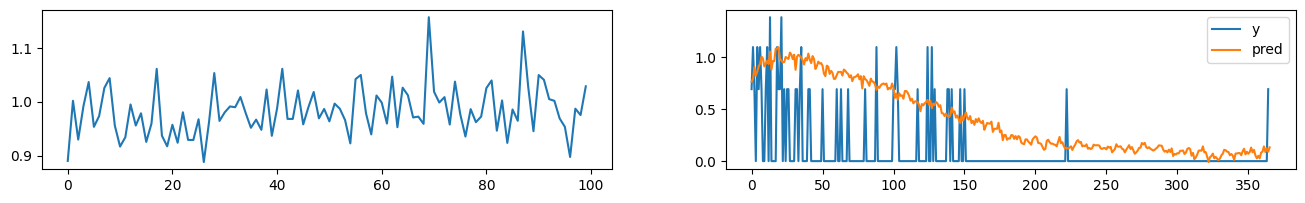

0 - sales_loss: 0.6011288419365883, dow_loss: 1.947149500846863, month_loss: 2.258079549074173, holiday_loss: 0.11098707363009452, price_loss: 0.0005210954329231753, lr: 0.001:  16%|█▌        | 270/1678 [01:30<11:46,  1.99it/s] 

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")

def num_temporal_loss_fn(pred, y, mask, padding_mask):
    y = torch.gather(y, index=mask, dim=1)
    pred = torch.gather(pred, index=mask, dim=1)
    loss = mse_loss(pred, y)
    loss = torch.where(padding_mask==1, loss, 0)
    loss = loss.sum() / padding_mask.sum()
    return loss

def cat_temporal_loss_fn(pred, y, mask, padding_mask):
    y = torch.gather(y, index=mask, dim=1).to(torch.long)

    pred_mask = mask.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
    pred = torch.gather(pred, index=pred_mask, dim=1)
    loss = ce_loss(pred.view(-1, pred.shape[-1]), y.view(-1)).view(y.shape)
    loss = torch.where(padding_mask==1, loss, 0)
    loss = loss.sum() / padding_mask.sum()
    return loss

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li, sales_loss_li, dow_loss_li, month_loss_li, holiday_loss_li, price_loss_li, window = [], [], [], [], [], [], 100

    for n, data in enumerate(pbar):
        model.train()
        optimizer.zero_grad()
        temporal_output_dict, static_output_dict, img_output, \
        temporal_decodingweight_dict, static_decodingweight, img_decodingweight, \
        static_masked_idx, img_masked_idx \
            = model(data_input)
        
        sales_loss = num_temporal_loss_fn(temporal_output_dict["sales"][:, 1:], data["sales"].to(device), data["sales_masked_idx"].unsqueeze(-1).to(device), data["sales_masked_padding_mask"].unsqueeze(-1).to(device))
        dow_loss = cat_temporal_loss_fn(temporal_output_dict["dow"][:, 1:], data["dow"].to(device), data["dow_masked_idx"].to(device), data["dow_masked_padding_mask"].to(device))
        month_loss = cat_temporal_loss_fn(temporal_output_dict["month"][:, 1:], data["month"].to(device), data["month_masked_idx"].to(device), data["month_masked_padding_mask"].to(device))
        holiday_loss = cat_temporal_loss_fn(temporal_output_dict["holiday"][:, 1:], data["holiday"].to(device), data["holiday_masked_idx"].to(device), data["holiday_masked_padding_mask"].to(device))
        price_loss = num_temporal_loss_fn(temporal_output_dict["price"][:, 1:], data["price"].to(device), data["price_masked_idx"].unsqueeze(-1).to(device), data["price_masked_padding_mask"].unsqueeze(-1).to(device))

        loss = (sales_loss + dow_loss + month_loss + holiday_loss + price_loss)/5

        loss.backward()
        optimizer.step()

        loss_li.append(loss.item())
        sales_loss_li.append(sales_loss.item())
        dow_loss_li.append(dow_loss.item())
        month_loss_li.append(month_loss.item())
        holiday_loss_li.append(holiday_loss.item())
        price_loss_li.append(price_loss.item())
        pbar.set_description(f"{e} - sales_loss: {np.mean(sales_loss_li[-window:])}, \
dow_loss: {np.mean(dow_loss_li[-window:])}, \
month_loss: {np.mean(month_loss_li[-window:])}, \
holiday_loss: {np.mean(holiday_loss_li[-window:])}, \
price_loss: {np.mean(price_loss_li[-window:])}, \
lr: {optimizer.param_groups[0]['lr']}")

        if n %20 == 0:
            idx = 0
            plt.figure(figsize=(25,12))
            nrows, ncols = 5, 3
            clear_output(wait=True)

            # Loss
            plt.subplot(nrows, ncols, 1)
            plt.plot(loss_li[-window:])

            # Sample
            plt.subplot(nrows, ncols, 2)
            plt.plot(data["sales"][idx], label="y")
            plt.plot(temporal_output_dict["sales"][idx].detach().cpu(), label="pred")
            plt.legend()

            plt.show()

epoch = 5
for e in range(epoch):
    train(e)
    scheduler.step()

# Eval

In [ ]:
model.eval()
pbar = tqdm(valid_dataloader)

for n, data in enumerate(pbar):
    with torch.no_grad():
        sales_output, day_output, dow_output, month_output, holiday_output, price_output, index_output, color_output, graphic_output, prod_output, img_output,\
            temp_keep_mask, static_idx_keep, img_idx_keep\
            = model(data["sales"].to(device),
                data["day"].to(device), data["dow"].to(device), data["month"].to(device), data["holiday"].to(device), data["price"].to(device),
                data["index"].to(device),  data["color"].to(device),  data["graphic"].to(device),  data["prod"].to(device),
                data["img_input"].to(device),
                data["sales_idx_keep"].to(device), data["sales_revert"].to(device),
                data["day_idx_keep"].to(device), data["day_revert"].to(device),
                data["dow_idx_keep"].to(device), data["dow_revert"].to(device),
                data["month_idx_keep"].to(device), data["month_revert"].to(device),
                data["holiday_idx_keep"].to(device), data["holiday_revert"].to(device),
                data["price_idx_keep"].to(device), data["price_revert"].to(device),
                data["temp_keep_padding_mask"].to(device), data["temp_revert_padding_mask"].to(device))

        if n %20 == 0:
            idx = 0
            plt.figure(figsize=(25,12))
            nrows, ncols = 5, 3
            clear_output(wait=True)
            
            # Sample
            plt.subplot(nrows, ncols, 2)
            valid_len = data["temp_revert_padding_mask"].max(dim=-1).indices[idx]
            valid_len = data["sales"].shape[-1] if valid_len == 0 else valid_len
            plt.plot(data["sales"][idx][:valid_len], label="y")
            plt.plot(sales_output[idx][1:valid_len].detach().cpu(), label="pred")
            plt.legend()

            # Img
            plt.subplot(nrows, ncols, 4)
            img_input = data["img_input"]
            img_input = img_input.permute(0,2,3,1)
            img_input = img_input.cpu().detach().numpy()
            plt.imshow(img_input[idx])

            plt.subplot(nrows, ncols, 5)
            img_output = unpatchify(img_output[:, 1:]).permute(0,2,3,1)
            img_output = img_output.cpu().detach().numpy()
            plt.imshow(img_output[idx])

            index_output = torch.argmax(index_output, dim=-1).detach().cpu().numpy()
            index_output = train_dataset.get_encoder_dict()["index_encoder"].inverse_transform(index_output[idx])
            index_y = train_dataset.get_encoder_dict()["index_encoder"].inverse_transform(data["index"][idx].numpy()[0])
            print(f"y: {index_y}, pred: {index_output}")

            color_output = torch.argmax(color_output, dim=-1).detach().cpu().numpy()
            color_output = train_dataset.get_encoder_dict()["color_encoder"].inverse_transform(color_output[idx])
            color_y = train_dataset.get_encoder_dict()["color_encoder"].inverse_transform(data["color"][idx].numpy()[0])
            print(f"y: {color_y}, pred: {color_output}")

            graphic_output = torch.argmax(graphic_output, dim=-1).detach().cpu().numpy()
            graphic_output = train_dataset.get_encoder_dict()["graphic_encoder"].inverse_transform(graphic_output[idx])
            graphic_y = train_dataset.get_encoder_dict()["graphic_encoder"].inverse_transform(data["graphic"][idx].numpy()[0])
            print(f"y: {graphic_y}, pred: {graphic_output}")

            prod_output = torch.argmax(prod_output, dim=-1).detach().cpu().numpy()
            prod_output = train_dataset.get_encoder_dict()["prod_encoder"].inverse_transform(prod_output[idx])
            prod_y = train_dataset.get_encoder_dict()["prod_encoder"].inverse_transform(data["prod"][idx].numpy()[0])
            print(f"y: {prod_y}, pred: {prod_output}")

            plt.show()
            input()

  0%|          | 0/6711 [00:00<?, ?it/s]

  0%|          | 0/6711 [00:04<?, ?it/s]


KeyError: 'sales_idx_keep'